# Centroid Pieces (Op20)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from import_casa import casa

In [4]:
from gensim.models.keyedvectors import KeyedVectors

In [5]:
path = casa.get_data_path() / "cadet/op20/ft-2020.kv"
kv = KeyedVectors.load(str(path))
kv.vectors.shape

[INFO] 2021-01-27 13:18:10,354 gensim.utils: loading Word2VecKeyedVectors object from E:\LangOn\casa\data\cadet\op20\ft-2020.kv
[INFO] 2021-01-27 13:18:10,659 gensim.utils: setting ignored attribute vectors_norm to None
[INFO] 2021-01-27 13:18:10,660 gensim.utils: setting ignored attribute vectors_vocab_norm to None
[INFO] 2021-01-27 13:18:10,661 gensim.utils: setting ignored attribute vectors_ngrams_norm to None
[INFO] 2021-01-27 13:18:10,661 gensim.utils: setting ignored attribute buckets_word to None
[INFO] 2021-01-27 13:18:10,662 gensim.utils: loaded E:\LangOn\casa\data\cadet\op20\ft-2020.kv


(9851, 200)

## Hierarchical Clustering

In [6]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
M = kv.vectors
distM = pdist(M, metric='correlation')
print(distM) # return a condensed distance matrix 

[0.91984152 0.7606702  0.87190527 ... 0.3591147  1.0122767  0.93455383]


In [9]:
ldata = linkage(distM, method='complete')

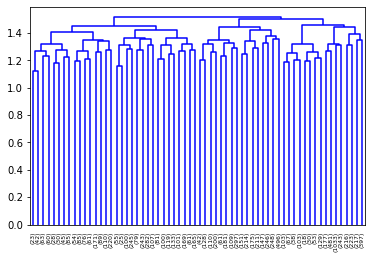

In [10]:
dn = dendrogram(ldata, truncate_mode='level', p=5)

## Construct Centroid Pieces from clustering

In [14]:
import numpy as np
def find_centroid(vectors):
    if len(vectors) == 1:
        return 0
    vec_matrix = np.vstack(vectors)
    centroid_vec = np.mean(vec_matrix, 0)
    corrs = [np.corrcoef(x, centroid_vec)[0,1] for x in vec_matrix]
    max_corr_idx = np.argmax(corrs)
    return max_corr_idx

In [16]:
from collections import defaultdict
clusters = defaultdict(list)
cluster_labels = fcluster(ldata, t=1, criterion='distance')
for word_i, cluster_i in enumerate(cluster_labels):
    clusters[cluster_i].append(kv.index2word[word_i])

print(f"Total {len(clusters)} Clusters")
data_items = []
for idx in sorted(clusters.keys(), key=lambda x: -np.mean([len(x)-1 for x in clusters[x]])):
    words = clusters[idx]
    cluster_idx = idx
    cluster_size = len(words)
    if len([x for x in words if len(x)>1]) < 3:
        continue
    centroid_id = find_centroid([kv.get_vector(w) for w in words])
    word_sample = ' '.join(sorted(words, key=lambda x: -len(x))[:10])
    
    centroid = words[centroid_id]
    print(f"{cluster_idx:03d}({cluster_size:>3d}): [{centroid}] {word_sample}")
    data_items.append([cluster_idx, cluster_size, centroid, " ".join(words)])

Total 532 Clusters
087( 14): [只能退租再辦?退租後] 老客戶加碼。謝謝漂亮大方的副座! 加碼。謝謝漂亮大方的副座! 加碼。謝謝漂亮大方的副 老客戶哩?老客戶哩? 只能退租再辦?退租後 已經3門的老客戶 多久能辦雙11 只能退租再辦 終生終生 砂
044( 12): [>] ---------------- ================ -------- ======== ==== == >> = > \
198( 12): [signal] opensignal speedtest peedtest ensignal signal test peed sign 😓 ฅ
103( 19): [iphone12] iphone12 iphone11 airpods 的iphone 、iphone 買iphone iphone 256gb airpo ipad
360( 31): [catchplay] catchplay friday影音 myvideo netflix tchplay friday pchome switch video kkbox
201( 28): [與台灣大哥大] 中華電信、台灣大哥大 中華電信、遠傳電信 、台灣大哥大 與台灣大哥大 台灣大哥大的 台灣大哥大 、台灣之星 、亞太電信 、遠傳電信 。亞太電信
493( 49): [登入成功後按右下角的] 登入會員帳號就是門號密碼不知道 登入成功後按右下角的會員 帳號就是門號密碼不知道 登入成功後按右下角的 按忘記密碼進行查詢 帳號就是門號密碼 點選輸入推薦碼 按忘記密碼進行 登入成功後按 遠傳心生活
155( 23): [......] ......... ........ ....... ...... ..... xdddd .... 種花電信 xddd ...我
259( 27): [5g] 中華電信5g 台灣之星5g 5g網路 升級5g 遠傳5g 台灣5g 中華5g 台星5g 亞太5g 申辦5g
051( 16): [from] -----sent fromon ----- ---- from jptt sent --- .-- 。--
320( 17): [中華電信] 中華電信的 的中華電信 是中華電信 中華電信 一家電信 目前使用 中華電 家電信 的電信 

In [17]:
import pandas as pd

In [18]:
spm_centroids = pd.DataFrame(data_items, columns="cluster_idx,cluster_size,centroid,words".split(","))

In [19]:
spm_centroids.to_csv(casa.get_data_path() / "cadet/op20/spm_centroids_op20.csv")